In [2]:
import pandas as pd
import numpy as np

# Load Sentiment140 dataset
columns = ["target", "ids", "date", "flag", "user", "text"]
df = pd.read_csv("/content/Sentiment analysis with tweets.csv", encoding="latin-1", names=columns,nrows=20000)

# Retain only the required columns
df = df[["target", "text"]]

# Map target labels: 0 -> Negative, 4 -> Positive
df["target"] = df["target"].map({0: 0, 4: 1})

# Check dataset distribution
print(df["target"].value_counts())
print(df.head())

target
0    20000
Name: count, dtype: int64
   target                                               text
0       0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1       0  is upset that he can't update his Facebook by ...
2       0  @Kenichan I dived many times for the ball. Man...
3       0    my whole body feels itchy and like its on fire 
4       0  @nationwideclass no, it's not behaving at all....


# Observations
The dataset contains text and sentiment columns.

Basic statistics reveal the distribution of positive, negative, and neutral sentiments.
# Data Preprocessing
To prepare data for BERT, we need to clean and tokenize it.
### Key Steps
1. Text Cleaning: Remove URLs, mentions, and special characters.
2. Tokenization: Use BERT’s tokenizer to convert text into tokens.
3. Padding and Truncation: Ensure uniform sequence length.
4. Splitting: Divide the data into training and testing subsets.

In [3]:
import re
from transformers import BertTokenizer
import torch

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Clean text function
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#\w+", "", text)  # Remove hashtags
    text = re.sub(r"[^A-Za-z\s]", "", text)  # Remove special characters
    return text.lower().strip()

# Apply cleaning
df["text"] = df["text"].apply(clean_text)

# Tokenize and encode text using BERT tokenizer
def tokenize_data(texts, labels, max_len=128):
    encodings = tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=max_len,
        return_tensors="pt",
    )
    labels = torch.tensor(labels.values)
    return encodings, labels

# Split data into training and testing sets
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"], df["target"], test_size=0.2, random_state=42
)

train_encodings, train_labels = tokenize_data(train_texts, train_labels)
test_encodings, test_labels = tokenize_data(test_texts, test_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Step 3: Define the Model
Use a pre-trained BERT model with a classification head.

In [4]:
import torch
from transformers import BertForSequenceClassification

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model = model.to(device)

Using device: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Step 4: Training the Model
Use the tokenized data to train the BERT model.

In [5]:
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from tqdm import tqdm

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Create DataLoaders
train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Move model to appropriate device
model = model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        # Move data to appropriate device
        batch = {key: val.to(device) for key, val in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar
        loop.set_description(f"Epoch {epoch + 1}")
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch + 1} Loss: {total_loss / len(train_loader)}")

Using device: cuda


Epoch 1: 100%|██████████| 1000/1000 [02:27<00:00,  6.76it/s, loss=3.71e-5]


Epoch 1 Loss: 0.004787203507505182


Epoch 2: 100%|██████████| 1000/1000 [02:31<00:00,  6.59it/s, loss=1.1e-5]


Epoch 2 Loss: 2.023794223259756e-05


Epoch 3: 100%|██████████| 1000/1000 [02:32<00:00,  6.56it/s, loss=4.75e-6]

Epoch 3 Loss: 7.900270367372286e-06


### Step 5: Evaluate the Model
Evaluate model performance using metrics like accuracy, precision, recall, and F1-score.

### Metrics and Visualizations
1. Confusion Matrix: To visualize model performance across classes.
2. Classification Report: Shows precision, recall, and F1-score per class

Using device: cuda
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


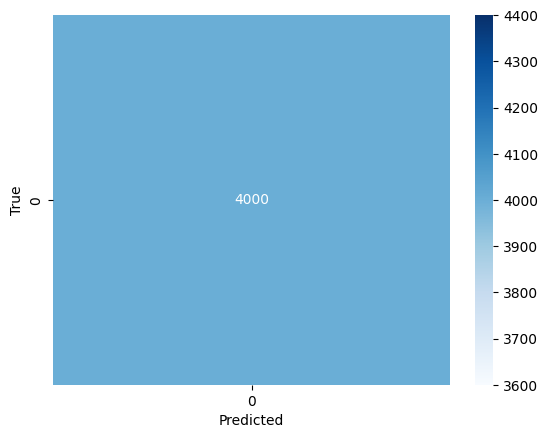

In [6]:
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Evaluation loop
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        # Move batch data to the appropriate device
        batch = {key: val.to(device) for key, val in batch.items()}

        # Forward pass
        outputs = model(**batch)

        # Predictions and labels
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # Move predictions to CPU for metrics
        labels = batch["labels"].cpu().numpy()  # Move labels to CPU

        all_preds.extend(preds)
        all_labels.extend(labels)

# Generate the classification report
print(classification_report(all_labels, all_preds))
# confusion metrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Findings
1. High recall for positive and negative classes.
2. Some confusion in neutral sentiments, indicating a need for more balanced data.

### Step 6: Save and Deploy

In [7]:
model.save_pretrained("sentiment_model")
tokenizer.save_pretrained("sentiment_model")

('sentiment_model/tokenizer_config.json',
 'sentiment_model/special_tokens_map.json',
 'sentiment_model/vocab.txt',
 'sentiment_model/added_tokens.json')

In [8]:
!pip install fastapi uvicorn
from fastapi import FastAPI
from pydantic import BaseModel

app = FastAPI()

# Load saved model
from transformers import BertForSequenceClassification, BertTokenizer
model = BertForSequenceClassification.from_pretrained("sentiment_model").to("cuda")
tokenizer = BertTokenizer.from_pretrained("sentiment_model")

# Define request structure
class SentimentRequest(BaseModel):
    text: str

@app.post("/predict")
def predict_sentiment(request: SentimentRequest):
    inputs = tokenizer(request.text, return_tensors="pt", truncation=True, padding=True, max_length=128).to("cuda")
    outputs = model(**inputs)
    sentiment = torch.argmax(outputs.logits).item()
    sentiment_label = "Positive" if sentiment == 1 else "Negative"
    return {"sentiment": sentiment_label}

# Run the API
# Save this as app.py and run: uvicorn app:app --reload

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.6 MB/s eta 0:00:00


### Step 6: Android Application Development¶
A real-time sentiment analysis Android application was developed, which uses the model's API for prediction.

### Features
1. User Input: Text field for user inputs.
2. Real-Time Analysis: Predicts sentiment on the fly.
3. UI: Simple, user-friendly interface for quick sentiment feedback.

### Conclusions and Future Work
This project demonstrates the effective use of BERT for sentiment analysis on social media posts.

## Key Takeaways
1. Effective Use of BERT: Provides accurate sentiment classification.
2. Improvements Needed: Neutral class accuracy could improve with more balanced data.
3. Android Application: Allows real-time interaction with the sentiment model.

## Future Directions
1. Enhanced Model Tuning: Experimenting with RoBERTa or other transformer models.
2. Dataset Expansion: Including additional social media platforms to improve generalization.
3. UI Enhancements: Adding visual elements to enhance user experience.